In [1]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-5-nano",
    temperature=0,
    api_key=OPENAI_API_KEY
)

In [3]:
import networkx as nx

kg = nx.DiGraph()

In [4]:
from typing import TypedDict, List, Tuple

class KGState(TypedDict):
    knowledge_text: str
    question: str
    extracted_facts: List[Tuple[str, str, str]]
    answer: str

In [5]:
def extract_facts_node(state: KGState) -> KGState:
    prompt = f"""
You are extracting facts to build a semantic knowledge graph for a TV series.

Extract ONLY high-confidence, plot-relevant relationships that help answer
questions about characters, actions, and events in the story.

A valid fact MUST satisfy ALL of the following:
- It describes a concrete story event, relationship, or role
- It involves named characters, locations, or episodes
- The relationship represents a clear action, role, or interaction
- It is explicitly stated or strongly implied in the text
- It is NOT meta information, instructions, or analysis
- Avoid vague relations
- If a relationship is uncertain or abstract, SKIP it

Return each fact on a new line using EXACTLY this format:
(Entity1, Relationship, Entity2)

Do NOT explain the facts.
Do NOT return summaries.
Do NOT return anything except formatted facts.

Text:
{state['knowledge_text']}
"""


    response = llm.invoke(prompt)
    lines = response.content.split("\n")

    facts = []
    for line in lines:
        if "(" in line and ")" in line:
            raw = line.strip("()")
            parts = [p.strip() for p in raw.split(",")]
            if len(parts) >= 3:
                facts.append((parts[0], parts[1], ", ".join(parts[2:])))

    return {
        **state,
        "extracted_facts": facts
    }

In [6]:
def store_facts_node(state: KGState) -> KGState:
    for subject, relation, obj in state["extracted_facts"]:
        kg.add_edge(subject, obj, relation=relation)
    return state

In [7]:
def reason_node(state: KGState) -> KGState:
    prompt = f"""
Using the knowledge graph facts below, answer the question.

Facts:
{list(kg.edges(data=True))}

Question:
{state['question']}
"""

    response = llm.invoke(prompt)

    return {
        **state,
        "answer": response.content
    }

In [8]:
from langgraph.graph import StateGraph, END

graph = StateGraph(KGState)

graph.add_node("extract", extract_facts_node)
graph.add_node("store", store_facts_node)
graph.add_node("reason", reason_node)

graph.set_entry_point("extract")

graph.add_edge("extract", "store")
graph.add_edge("store", "reason")
graph.add_edge("reason", END)

app = graph.compile()

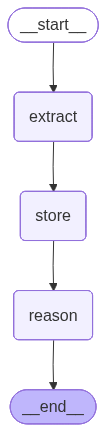

In [9]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [10]:
import requests
import pandas as pd

def fetch_episode_titles_from_wikipedia(url: str) -> str:

    headers = {
        "User-Agent": "Mozilla/5.0 (AgenticAI Project)"
    }

    response = requests.get(url, headers=headers)
    response.raise_for_status()

    tables = pd.read_html(response.text)

    for table in tables:
        if "Title" in table.columns:
            titles = table["Title"].astype(str).tolist()
            return "\n".join(titles)

    return "No episode table found."

In [11]:
wiki_links = [
    "https://en.wikipedia.org/wiki/Stranger_Things_season_1",
    "https://en.wikipedia.org/wiki/Stranger_Things_season_2",
    "https://en.wikipedia.org/wiki/Stranger_Things_season_3",
    "https://en.wikipedia.org/wiki/Stranger_Things_season_4",
    "https://en.wikipedia.org/wiki/Stranger_Things_season_5"
]

for link in wiki_links:
    print(f"\nIngesting: {link}")
    
    text = fetch_episode_titles_from_wikipedia(link)

    state: KGState = {
        "knowledge_text": text,
        "question": "",
        "extracted_facts": [],
        "answer": ""
    }

    app.invoke(state)



Ingesting: https://en.wikipedia.org/wiki/Stranger_Things_season_1


C:\Users\ssury\AppData\Local\Temp\ipykernel_9488\2051537652.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)



Ingesting: https://en.wikipedia.org/wiki/Stranger_Things_season_2


C:\Users\ssury\AppData\Local\Temp\ipykernel_9488\2051537652.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)



Ingesting: https://en.wikipedia.org/wiki/Stranger_Things_season_3


C:\Users\ssury\AppData\Local\Temp\ipykernel_9488\2051537652.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)



Ingesting: https://en.wikipedia.org/wiki/Stranger_Things_season_4


C:\Users\ssury\AppData\Local\Temp\ipykernel_9488\2051537652.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)



Ingesting: https://en.wikipedia.org/wiki/Stranger_Things_season_5


C:\Users\ssury\AppData\Local\Temp\ipykernel_9488\2051537652.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


In [24]:
question_state: KGState = {
    "knowledge_text": "",
    "question": "what is upside down?",
    "extracted_facts": [],
    "answer": ""
}

final_state = app.invoke(question_state)
print(final_state["answer"])

Upside Down is a wormhole to another realm.


In [13]:
question_state: KGState = {
    "knowledge_text": "",
    "question": "Who gets stuck in Russia? and how did the rescue happen?",
    "extracted_facts": [],
    "answer": ""
}

final_state = app.invoke(question_state)
print(final_state["answer"])

- Who gets stuck in Russia? Jim Hopper.

- How did the rescue happen? Joyce Byers and Murray Bauman go to Russia, deliver ransom to Yuri and subdue him, and then crash in the desert as part of their escape, thereby rescuing Hopper.


In [14]:
question_state: KGState = {
    "knowledge_text": "",
    "question": "How is Jonathan Byers related to Will Byers?",
    "extracted_facts": [],
    "answer": ""
}

final_state = app.invoke(question_state)
print(final_state["answer"])

Jonathan Byers is Will Byers's brother (Will's older brother).


In [15]:
question_state: KGState = {
    "knowledge_text": "",
    "question": "What does Steve do?",
    "extracted_facts": [],
    "answer": ""
}

final_state = app.invoke(question_state)
print(final_state["answer"])

Steve Harrington works at the Starcourt Mall ice cream parlor.


Nodes: 252
Edges: 273


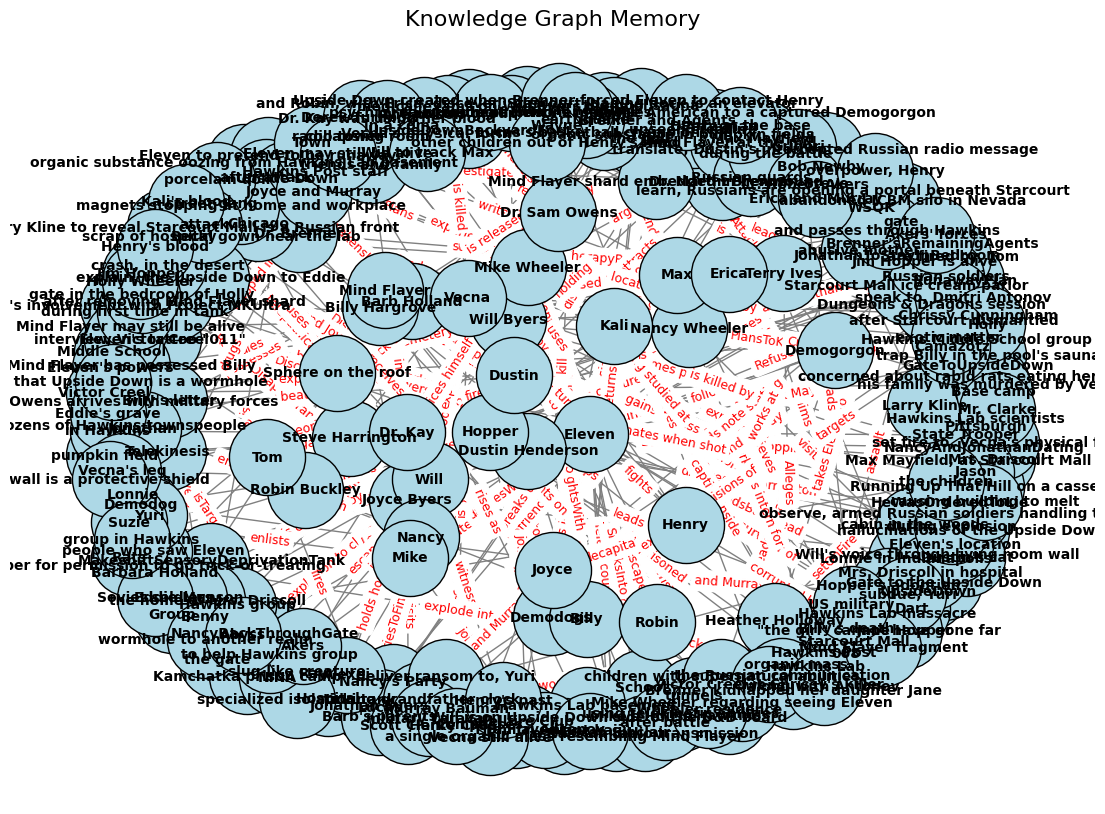

In [16]:
import matplotlib.pyplot as plt
import networkx as nx

# Basic sanity check
print("Nodes:", kg.number_of_nodes())
print("Edges:", kg.number_of_edges())

plt.figure(figsize=(14, 10))

# Layout algorithm (good balance for most graphs)
pos = nx.spring_layout(kg, seed=42, k=0.9)

# Draw nodes
nx.draw_networkx_nodes(
    kg,
    pos,
    node_size=3000,
    node_color="lightblue",
    edgecolors="black"
)

# Draw edges
nx.draw_networkx_edges(
    kg,
    pos,
    arrowstyle="->",
    arrowsize=15,
    edge_color="gray"
)

# Draw node labels
nx.draw_networkx_labels(
    kg,
    pos,
    font_size=10,
    font_weight="bold"
)

# Draw edge labels (relationships)
edge_labels = nx.get_edge_attributes(kg, "relation")
nx.draw_networkx_edge_labels(
    kg,
    pos,
    edge_labels=edge_labels,
    font_color="red",
    font_size=9
)

plt.title("Knowledge Graph Memory", fontsize=16)
plt.axis("off")
plt.show()

In [29]:
# Keep only important nodes (high degree)
MIN_DEGREE = 3

important_nodes = [
    node for node, degree in dict(kg.degree()).items()
    if degree >= MIN_DEGREE
]

kg_filtered = kg.subgraph(important_nodes).copy()

print("Filtered nodes:", kg_filtered.number_of_nodes())
print("Filtered edges:", kg_filtered.number_of_edges())

Filtered nodes: 43
Filtered edges: 70


Nodes: 43
Edges: 70


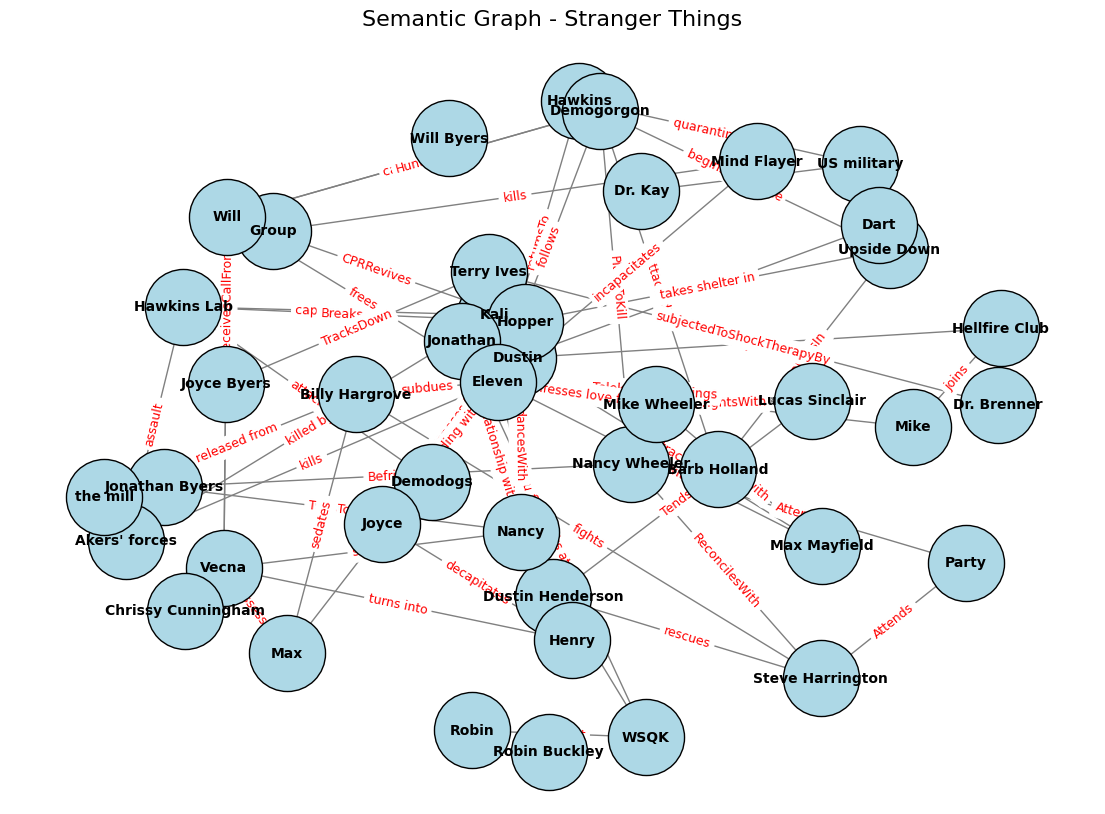

In [30]:
import matplotlib.pyplot as plt
import networkx as nx

# Basic sanity check
print("Nodes:", kg_filtered.number_of_nodes())
print("Edges:", kg_filtered.number_of_edges())

plt.figure(figsize=(14, 10))

# Layout algorithm (good balance for most graphs)
pos = nx.spring_layout(kg_filtered, seed=42, k=0.9)

# Draw nodes
nx.draw_networkx_nodes(
    kg_filtered,
    pos,
    node_size=3000,
    node_color="lightblue",
    edgecolors="black"
)

# Draw edges
nx.draw_networkx_edges(
    kg_filtered,
    pos,
    arrowstyle="->",
    arrowsize=15,
    edge_color="gray"
)

# Draw node labels
nx.draw_networkx_labels(
    kg_filtered,
    pos,
    font_size=10,
    font_weight="bold"
)

# Draw edge labels (relationships)
edge_labels = nx.get_edge_attributes(kg_filtered, "relation")
nx.draw_networkx_edge_labels(
    kg_filtered,
    pos,
    edge_labels=edge_labels,
    font_color="red",
    font_size=9
)

plt.title("Semantic Graph - Stranger Things", fontsize=16)
plt.axis("off")
plt.show()